In [106]:
!gcloud services enable ml.googleapis.com
!gcloud services enable compute.googleapis.com

In [1]:
!mkdir friday_training

mkdir: cannot create directory ‘friday_training’: File exists


In [ ]:
!touch ./friday_training/__init__.py

In [8]:
%%writefile ./friday_training/train.py
import datetime
import xgboost as xgb
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import subprocess
from google.cloud import storage
import pandas as pd
import numpy as np

from sklearn import preprocessing
from math import sqrt
import datetime
#import matplotlib.pyplot as plt
#import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

# Fill in your Cloud Storage bucket name
BUCKET_ID = 'friday_demo2'

public_bucket = storage.Client().bucket(BUCKET_ID)
blob = public_bucket.blob('Data/train.csv')
blob.download_to_filename('train.csv')

blob = public_bucket.blob('Data/test.csv')
blob.download_to_filename('test.csv')

#Read the data from the bucket
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes


# categorical columns to convert
categorical_columns = ["Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years",
                       "Marital_Status", "Product_Category_1"]


# Join Train and Test Dataset so it can be cleaned all at once
train['source']='train'
test['source']='test'

data = pd.concat([train,test], ignore_index = True, sort = False)

#Get index of all columns with product_category_1 equal 19 or 20 from train and remove since not populated
condition = data.index[(data.Product_Category_1.isin([19,20])) & (data.source == "train")]
data = data.drop(condition)

# define example
#community_area = [num for num in range(78)]
# data = array(data)
#print(community_area)
# one hot encode

# convert categorical data to to numerical values.
# convert data in categorical columns to numerical values
"""encoders = {col:LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    data[col] = encoders[col].fit_transform(data[col])
    #data[col] = to_categorical(data[col])
    #print(data[col])
"""
data = pd.get_dummies(data, columns=categorical_columns, drop_first=False)
#print(data)

totalitem = data['User_ID'].value_counts().sort_index()
totalpurchase = data.groupby('User_ID').sum()['Purchase']
tot = pd.concat([totalitem, totalpurchase], axis =1, keys = ['Total_products', 'Total_purchase'])
data = pd.merge(data, tot, left_on = 'User_ID', right_index = True)
    
#Divide into test and train
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

# remove column we are trying to predict ('Purchase') from features list and also removed product category 2 and 3 due to missing values
train_features = train.drop(['Purchase', 'Product_Category_2', 'Product_Category_3', 'Product_ID', 'User_ID'], axis=1)
test_features = test.drop(['Purchase', 'Product_Category_2', 'Product_Category_3', 'Product_ID', 'User_ID'], axis=1)
# create training labels list
train_labels = train[['Purchase']]
test_labels = test[['Purchase']]

# load data into DMatrix object
dtrain = xgb.DMatrix(train_features, train_labels)
dtest = xgb.DMatrix(test_features)
# train model
bst = xgb.train({}, dtrain, 20)


# Export the model to a file
model = 'model.bst'
bst.save_model('./model.bst')

# Upload the model to Cloud Storage
bucket = storage.Client().bucket(BUCKET_ID)
blob = bucket.blob(model)
blob.upload_from_filename(model)


#tree based learner for onehotencode
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 700)

xg_reg.fit(train_features,train_labels)

preds = xg_reg.predict(train_features)
rmse = np.sqrt(mean_squared_error(train_labels, preds))
print("RMSE: %f" % (rmse))


Writing ./friday_training/train.py


In [7]:
#tree based learner for onehotencode
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 700)

fit = xg_reg.fit(train_features,train_labels)

preds = xg_reg.predict(train_features)
rmse = np.sqrt(mean_squared_error(train_labels, preds))
print("RMSE: %f" % (rmse))

[20:59:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 2834.131247


In [ ]:
from sklearn.model_selection import StratifiedKFold
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(xg_reg, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(train_features, train_labels)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

In [5]:
#k fold cross validation
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=700,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


            

In [6]:
cv_results.tail(50)
#print((cv_results["test-rmse-mean"]).tail(1))

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
650,2861.743408,3.969492,2829.502034,1.290435
651,2861.715739,3.976838,2829.457275,1.289251
652,2861.658936,3.945499,2829.347412,1.323712
653,2861.609375,3.946513,2829.271078,1.333679
654,2861.597737,3.929066,2829.218180,1.349680
655,2861.587565,3.922481,2829.164957,1.353497
656,2861.545898,3.920122,2829.072347,1.374786
657,2861.490886,3.943720,2828.960449,1.339713
658,2861.376058,3.859949,2828.805501,1.402136
659,2861.243978,4.016350,2828.602864,1.250041


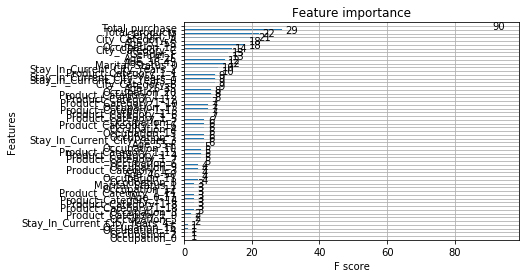

In [9]:
import matplotlib.pyplot as plt
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [10]:
xgb = XGBRegressor()
xgb.fit(train_features, train_labels)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = train_features.columns)
imp = imp.sort_values(['Importance'], ascending = False)

print(imp)

[04:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                               Importance
Product_Category_1_1             0.468180
Product_Category_1_6             0.119434
Product_Category_1_10            0.060590
Product_Category_1_5             0.057972
Product_Category_1_16            0.040027
Product_Category_1_4             0.039892
Product_Category_1_11            0.037587
Product_Category_1_8             0.032687
Product_Category_1_13            0.031161
Product_Category_1_15            0.022493
Product_Category_1_7             0.021438
Product_Category_1_12            0.020889
Product_Category_1_2             0.020630
Product_Category_1_18            0.012612
Product_Category_1_14            0.004292
Product_Category_1_3             0.003350
Product_Category_1_9             0.003219
Total_products                   0.001405
Total_purchase                   0.000993
Occupation_19                    

In [ ]:
from sklearn.model_selection import learning_curve, GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.07, n_estimators=1000, max_depth=5,
 min_child_weight=1.5, gamma=0.03, subsample=0.95, colsample_bytree=0.4,
 nthread=4, scale_pos_weight=1, seed=27, reg_alpah=0.75, reg_lambda=0.45), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_features,train_labels)
gsearch1.best_params_, gsearch1.best_score_

In [6]:
import time

# Define a timestamped job name
JOB_NAME = "friday_training_{}".format(int(time.time()))
BUCKET_NAME = 'friday_demo2'

In [7]:

# Submit the training job:
!gcloud ai-platform jobs submit training $JOB_NAME \
  --job-dir gs://$BUCKET_NAME/friday_job_dir \
  --package-path ./friday_training \
  --module-name friday_training.train \
  --region us-east1 \
  --runtime-version=1.12 \
  --python-version=3.5 \
  --scale-tier BASIC \
  --stream-logs \
  -- \
  --bucket-name $BUCKET_NAME

Job [friday_training_1564748775] submitted successfully.
INFO	2019-08-02 12:26:23 +0000	service		Validating job requirements...
INFO	2019-08-02 12:26:23 +0000	service		Job creation request has been successfully validated.
INFO	2019-08-02 12:26:23 +0000	service		Job friday_training_1564748775 is queued.
INFO	2019-08-02 12:26:24 +0000	service		Waiting for job to be provisioned.
INFO	2019-08-02 12:26:26 +0000	service		Waiting for training program to start.
INFO	2019-08-02 12:27:05 +0000	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://friday_demo2/friday_job_dir/packages/25e48d8a9e40cdc2ec42184a290d5beda376cbb389f403c512028a4a177808f0/friday_training-0.0.0.tar.gz"],  "python_module": "friday_training.train",  "args": ["--bucket-name", "friday_demo2"],  "region": "us-east1",  "runtime_version": "1.12",  "job_dir": "gs://friday_demo2/friday_job_dir",  "run_on_raw_vm": true,  "python_

In [83]:
MODEL_NAME = "BlackFridayPredictor"
VERSION_NAME = "friday_predictor"
#VERSION_NAME = "friday_predictor_{}".format(int(time.time()))

In [42]:
!gcloud ml-engine models create $MODEL_NAME --regions us-east1

ERROR: (gcloud.ml-engine.models.create) Resource in project [ml-sandbox-1-191918] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


In [29]:
!gcloud ml-engine versions create $VERSION_NAME \
  --model=$MODEL_NAME \
  --framework=xgboost \
  --origin=gs://$BUCKET_NAME/ \
  --python-version=3.5 \
  --runtime-version=1.12

Creating version (this might take a few minutes)......done.


In [8]:
test_features_10 = test_features.head(10)
test_features_10

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Age_Count,Occupation_Count,Product_Category_1_Count,Product_Category_2_Count,Product_Category_3_Count,Product_ID_Count
550068,1000004,1216,1,4,7,1,2,1,0,10,0,64902,83667,200699,20230,541656,1333
550069,1000009,1063,1,2,17,2,0,0,2,4,0,311554,57076,28791,37165,541656,371
550070,1000010,2799,0,3,1,1,4,1,4,13,0,155898,67329,215950,78834,541656,217
550071,1000010,1379,0,3,1,1,4,1,3,8,0,155898,67329,16756,8177,541656,23
550072,1000011,535,0,2,1,2,1,0,3,4,9,311554,67329,16756,37165,13115,781
550073,1000013,3407,1,4,1,2,3,1,1,2,12,64902,67329,34056,4123,39968,413
550074,1000013,1480,1,4,1,2,3,1,0,10,12,64902,67329,200699,20230,39968,602
550075,1000013,3617,1,4,1,2,3,1,1,3,6,64902,67329,34056,36705,16532,242
550076,1000015,1543,1,2,7,0,1,0,9,12,13,311554,83667,7373,15054,46469,166
550077,1000022,673,1,1,15,0,4,0,4,13,0,141209,17257,215950,78834,541656,523


In [56]:
DATA_FORMAT="text" # JSON data format
MODEL_NAME = "BlackFridayPredictor"
VERSION_NAME = "friday_predictor"
REGION='us-east1'
JOB_NAME = "friday_training_{}".format(int(time.time()))


In [77]:
INPUT_FILE="data.json"

!gcloud ai-platform predict --model $MODEL_NAME --version \
  $VERSION_NAME --json-instances $INPUT_FILE



[16196.408203125, 10362.009765625]


In [76]:
%%writefile $INPUT_FILE
[1000004,1216,1,4,7,1,2,1,0,10,0,64902,83667,200699,20230,541656,1333]
[1000009,1063,1,2,17,2,0,0,2,4,0,311554,57076,28791,37165,541656,371]

Overwriting data.json
